## Basic regression: Predict fuel efficiency

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [78]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

for m in mpl, np, pd, sns, tf, keras:
    print(m.__name__, m.__version__)

matplotlib 3.3.1
numpy 1.18.5
pandas 1.1.0
seaborn 0.10.1
tensorflow 2.3.1
tensorflow.keras 2.4.0


## Get the Auto MPG dataset

In [18]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
              'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)


In [21]:
raw_dataset.shape

(398, 8)

In [22]:
raw_dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

In [19]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

In [20]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [23]:
dataset = dataset.dropna()

In [24]:
dataset.shape

(392, 8)

## Origin to one-hot encoding

In [25]:
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})

In [26]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data into train and test

In [27]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data

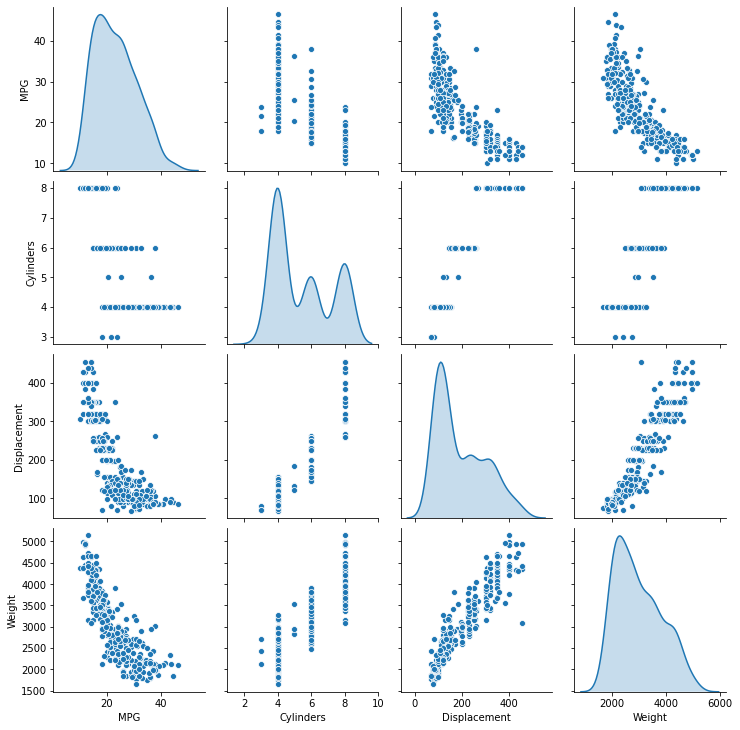

In [29]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], 
            diag_kind='kde')

In [30]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels

In [37]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.shape, train_labels.shape

((314, 9), (314,))

## Normalization

In [39]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


## The Normalization layer

In [40]:
normalizer = preprocessing.Normalization()

In [41]:
normalizer.adapt(np.array(train_features))

In [44]:
print(normalizer.mean)

<tf.Variable 'mean:0' shape=(9,) dtype=float32, numpy=
array([   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
          0.178,    0.197,    0.624], dtype=float32)>


In [47]:
print(normalizer.variance)

<tf.Variable 'variance:0' shape=(9,) dtype=float32, numpy=
array([     2.88 ,  10850.414,   1446.699, 709896.8  ,      7.755,
           13.467,      0.147,      0.158,      0.235], dtype=float32)>


In [48]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

In [49]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [50]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [51]:
# run the untrained model on first 10 horsepower values

print(horsepower[:10])
horsepower_model.predict(horsepower[:10])

[ 75.  88. 160.  63.  67.  90.  60.  67.  95.  88.]


array([[-0.681],
       [-0.384],
       [ 1.256],
       [-0.954],
       [-0.863],
       [-0.339],
       [-1.023],
       [-0.863],
       [-0.225],
       [-0.384]], dtype=float32)

In [52]:
# model compile

horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [53]:
# model training

history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # calcalate validation results on 20% of the training data
    validation_split=0.2
)

In [54]:
# visualize the model's training progress using the states stored in the history object.

hist = pd.DataFrame(history.history)
# add epoch column
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804037,4.177984,95
96,3.805208,4.162226,96
97,3.805344,4.174585,97
98,3.802556,4.188158,98
99,3.806231,4.219000,99


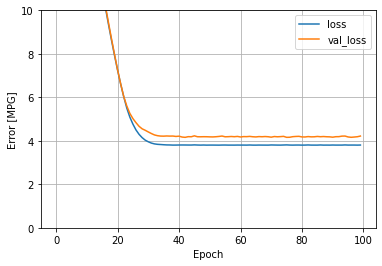

In [58]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

In [60]:
# collect the results on the test data set

test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [61]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [62]:
x.shape

TensorShape([251])

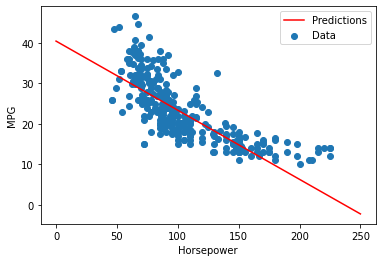

In [66]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='r', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()
    
plot_horsepower(x, y)

In [72]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [70]:
linear_model.predict(train_features[:10])

array([[ 0.398],
       [-1.189],
       [-1.319],
       [-0.521],
       [ 1.2  ],
       [-1.839],
       [ 1.086],
       [-0.127],
       [-1.025],
       [ 1.654]], dtype=float32)

In [71]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.016],
       [-0.756],
       [ 0.186],
       [-0.222],
       [-0.641],
       [-0.324],
       [ 0.39 ],
       [ 0.328],
       [-0.682]], dtype=float32)>

In [74]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [75]:
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 2.65 s, sys: 261 ms, total: 2.92 s
Wall time: 2.41 s


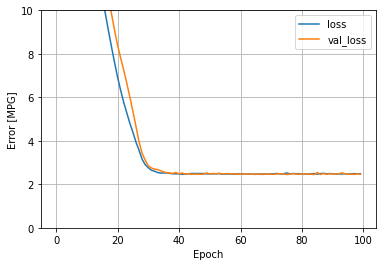

In [76]:
plot_loss(history)

In [77]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)